<h1> Captsone Project - The Battle Of Neighbourhoods - Live in Montreal </h1>

<h2> Introduction/Business Problem </h2>

Montreal, the 2nd most populated city in Canada has more than 4 millions population with a slow growth of 0.73% average every year. Montreal is also known as the 2nd largest economy in Canada by having a variety of businesses implementing themselves out there. As the nest of opportunities, many big tech companies started considering the city to have new offices - Google, Facebook, Microsoft to name a few. 

In the case where an individual had to relocate for a job opportunity, what would be the best locations we could suggest him? The purpose of this report is to identify what would be the best options thru a data driven research. We will identify amneties and venues based on their ratings from which we will offer options based on the relocator preferences.

This project targets mostly individuals that are not familiar with the city and that are searching a convenient borough where they can live. It will bring also options that fit the individual interest. As an example, an individual in the need of relocating, who likes parks, we expect him willing to be close to that type of venue.

<h2> Data Description </h2>

Data :<br>

- Montreal city boroughs names with their coordinates (latitude and longitude).
    - Data pulled from Wikipedia with the BeautifulSoup library. Alternatively, we could manually put the data in a CSV file.
    - Will be used with Foursquare API data to define the best venues of each boroughs.
    - We will use Folium to vizualize the different boroughs within Montreal.

- Top 10 venues based on ratings, which include their type(e.g : Restaurants, Bars, Malls, Parks, etc.) and their location (latitude and logitude).
    - For each 19 neighborhoods of Montreal. 
    - Clustering process with K-Mean algorithm to define more precisely where good venues and amneties are.
    - Data will be vizualized on folium generated map.
    - Will use the panda library to analyze and organize the data.

How : 

Several platform and techniques will be used during this report.
- Python as the interpreter language. As R, extensively used in Data analytic field. Useful for the diversity of libraries.
- Geocoders to convert address into coordinates value.
- Pandas for dataframe manipulation.
- Folium for map vizualization with our point of interest(Neighbordhoods and venues).
- Foursquare offers an API giving access to a wide range of data related to locations.
- As a clustering algorithm, K-Mean will be used to define ideal locations.


<h3>Lets start by preloading a list of libraries utilized in this project<h3>

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
import geocoder
import numpy as np
import json
from re import search
import re
import requests
import matplotlib.pyplot as plt
import unidecode
import branca.colormap as cm
from io import StringIO
import folium
import seaborn as sn
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
#from yellowbrick.cluster import KElbowVisualizer
from folium import plugins
from folium.plugins import HeatMap

<h3>We load the GoogleApi credentials and FoursquareApi credentials.</h3>

In [2]:

with open('Credentials.json') as f:
    data = json.load(f)
    MyGoogleAPIKey = data['MyGoogleAPIKey']
    CLIENT_ID = data['CLIENT_ID']
    CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = '20180605'


<h3>Function makes a request to the Google Maps Api with an address passed in arg.<br>
 Return the latitude and longitude of the address</h3>

In [3]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location']
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

<h3>Function taken from a previous lab of the curriculum.<br> 
It pulls a list of venues @ certain RADIUS of the lat/long past in arg.<br> 
We limit ourselves with #LIMIT records per lat/long.<br> 
The function will not be used just yet.</h3>

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000,LIMIT=200):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>We will use the geojson of Montreal(Found @ https://jmacman12.carto.com/tables/montreal_shapefile/public) which include the shape of all boroughs and towns.<br>
This geojson will serve as a baseline of boroughs(& towns) of Montreal city. This baseline will help on standardizing other datasets in this project.<br>
Boroughs is standadized by removing accents and lower casing the string value.</h3>

In [5]:
geojson = open('MontrealGeoShape.geojson', 'r',encoding="utf-8")
geojson = geojson.read()
geojson = json.loads(geojson)
for x in geojson['features']:
    x['properties']['district'] = unidecode.unidecode(x['properties']['district']).lower()

<h3>We load a "handcrafted" file of Montreal boroughs&town from Wikipedia<br>
We standardize the values to fit the geojson file loaded earlier<br>
For the missing towns/boroughs, we add them to the DF and call the GoogleApi for Lat/Long values.<h3>

In [6]:
dfMtlPos = pd.read_csv('MontrealBoroughsLatLong.csv')
for x,row in enumerate(dfMtlPos.iterrows()) :
    dfMtlPos.at[x,"Boroughs"] = unidecode.unidecode(dfMtlPos.at[x,"Boroughs"].lower())
    if dfMtlPos.at[x,"Boroughs"] == "southwest":
        dfMtlPos.at[x,"Boroughs"] = "le sud-ouest"
    if dfMtlPos.at[x,"Boroughs"] == "cote saint-luc":
        dfMtlPos.at[x,"Boroughs"] = "cote-saint-luc"
    if dfMtlPos.at[x,"Boroughs"] == "baie-d'urfe":
        dfMtlPos.at[x,"Boroughs"] = "baie d'urfe"
for x in geojson['features']:
    if x['properties']['district'] not in dfMtlPos['Boroughs'].values:
        latlong = get_coordinates(MyGoogleAPIKey,x['properties']['district'],verbose=False)
        dfMtlPos = dfMtlPos.append({'Boroughs': x['properties']['district'],'Type': 'T','Lat':latlong[0],'Long':latlong[1]},ignore_index=True)

<h3>Lets see the 33 Boroughs and Towns of Montreal. <br> 
Note the Type values that distinguish them.<h3>

In [7]:
dfMtlPos

Boroughs Type        Lat       Long
0                        pierrefonds-roxboro    B  45.509630 -73.819152
1        cote-des-neiges-notre-dame-de-grace    B  45.491151 -73.632653
2              mercier-hochelaga-maisonneuve    B  45.572978 -73.530795
3                                     verdun    B  45.454827 -73.569873
4                                    lasalle    B  45.430627 -73.634801
5                                ville-marie    B  45.508794 -73.555302
6                                    lachine    B  45.441347 -73.688585
7                              saint-laurent    B  45.498564 -73.749757
8                              saint-leonard    B  45.587473 -73.597010
9                               le sud-ouest    B  45.466107 -73.593866
10                                 outremont    B  45.514286 -73.609011
11                             montreal-nord    B  45.607198 -73.631474
12                 rosemont-la petite-patrie    B  45.551702 -73.583627
13                                mont-royal    B  45.507102 -73.587407
14                     ahuntsic-cartierville    B  45.544743 -73.668126
15             l'ile-bizard-sainte-genevieve    B  45.494889 -73.890756
16                                     anjou    B  45.615958 -73.569351
17  riviere-des-prairies-pointe-aux-trembles    B  45.673073 -73.518665
18      villeray-saint-michel-parc-extension    B  45.555334 -73.608310
19                            cote-saint-luc    T  45.468050 -73.672946
20                              beaconsfield    T  45.430931 -73.868283
21                                    dorval    T  45.450321 -73.750049
22                             pointe-claire    T  45.471966 -73.799019
23                                 westmount    T  45.485719 -73.595699
24                                  kirkland    T  45.456041 -73.862334
25                               baie d'urfe    T  45.416456 -73.916080
26                              montreal-est    T  45.632000 -73.506698
27                   sainte-anne-de-bellevue    T  45.403276 -73.950361
28                       dollard-des-ormeaux    T  45.489564 -73.820557
29                     le plateau-mont-royal    T  45.523153 -73.587043
30                                 hampstead    T  51.555646  -0.176175
31                            montreal-ouest    T  45.454725 -73.650236
32                                senneville    T  45.441342 -73.954872

<h3>Let's go over our DF and pull a set of venues @ #RADIUS (defined in meters).<br>
 Let's see the output.<h3>

In [8]:
dfMtlVenues = getNearbyVenues(names=dfMtlPos['Boroughs'],latitudes=dfMtlPos['Lat'],longitudes=dfMtlPos['Long'])
#Archive === dfMtlVenues = pd.read_csv("MontrealVenus.csv")
##Let's have a look at it.
dfMtlVenues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     pierrefonds-roxboro              45.509630              -73.819152   
1     pierrefonds-roxboro              45.509630              -73.819152   
2     pierrefonds-roxboro              45.509630              -73.819152   
3     pierrefonds-roxboro              45.509630              -73.819152   
4     pierrefonds-roxboro              45.509630              -73.819152   
...                   ...                    ...                     ...   
2821           senneville              45.441342              -73.954872   
2822           senneville              45.441342              -73.954872   
2823           senneville              45.441342              -73.954872   
2824           senneville              45.441342              -73.954872   
2825           senneville              45.441342              -73.954872   

                            ID                               Venue  \
0     4bdb01a53904a593993d489e          Restaurant Bombay Choupati   
1     51313bfee4b098c263c5d332                         Les 3 Maria   
2     4c49c15c3013a59398152de3                        Shahi Palace   
3     51411f87e4b091a07e3025ce                       Chateau Kebab   
4     4b65c853f964a5206eff2ae3                       Allo Mon Coco   
...                        ...                                 ...   
2821  4b770525f964a5201a752ee3  Ferme écologique du Cap St-Jacques   
2822  4b893745f964a5209b2332e3    AMT Gare Sainte-Anne-de-Bellevue   
2823  4b893653f964a520632332e3             AMT Gare de Baie d'Urfé   
2824  4b71df1cf964a52068612de3                         Hwy 40 west   
2825  4d41e5f21da9a0938bb45c3d                      Bureau en Gros   

      Venue Latitude  Venue Longitude                 Venue Category  
0          45.508404       -73.820454              Indian Restaurant  
1          45.504460       -73.817805          Portuguese Restaurant  
2          45.503766       -73.816520              Indian Restaurant  
3          45.502341       -73.815488      Middle Eastern Restaurant  
4          45.521944       -73.799609                 Breakfast Spot  
...              ...              ...                            ...  
2821       45.470569       -73.936040                           Farm  
2822       45.407761       -73.950959                  Train Station  
2823       45.419901       -73.915586                  Train Station  
2824       45.418365       -74.004722                          Trail  
2825       45.442603       -73.891743  Paper / Office Supplies Store  

[2826 rows x 8 columns]

<h3>Let's have a count per Neighborhood.<br>
We will only retain the neighborhood column and create a count of each occurence. <h3>

In [9]:
dfMtlVenuesCount = dfMtlVenues.groupby(['Venue Category','Neighborhood']).size()
dfMtlVenuesCount.columns = ['Venue Category	','Neighborhood', 'Count']
dfMtlVenuesCount.sort_values( ascending=False)
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount = dfMtlVenuesCount.groupby(['Neighborhood']).size()
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount.columns = ['Neighborhood', 'Total']
#dfMtlVenuesCountPerNeighborhood.sort_values(ascending=False, by=['Total'], inplace=True)
dfMtlVenuesCount

Neighborhood  Total
0                      ahuntsic-cartierville     49
1                                      anjou     36
2                                baie d'urfe     22
3                               beaconsfield     39
4        cote-des-neiges-notre-dame-de-grace     54
5                             cote-saint-luc     49
6                        dollard-des-ormeaux     44
7                                     dorval     46
8                                  hampstead     57
9                                   kirkland     44
10             l'ile-bizard-sainte-genevieve     28
11                                   lachine     26
12                                   lasalle     39
13                     le plateau-mont-royal     53
14                              le sud-ouest     56
15             mercier-hochelaga-maisonneuve     53
16                                mont-royal     56
17                              montreal-est     29
18                             montreal-nord     28
19                            montreal-ouest     47
20                                 outremont     50
21                       pierrefonds-roxboro     44
22                             pointe-claire     43
23  riviere-des-prairies-pointe-aux-trembles     26
24                 rosemont-la petite-patrie     52
25                             saint-laurent     49
26                             saint-leonard     50
27                   sainte-anne-de-bellevue     19
28                                senneville     18
29                                    verdun     57
30                               ville-marie     56
31      villeray-saint-michel-parc-extension     53
32                                 westmount     62

<h3>
We will display on a map the spread of venues within the boroughs of Montreal. <br>
We re-use a chropleth function obtained during the curriculum. <br>
A color argument is added to easily re-use the function throughout the analysis.<br>
We load our geojson data and our venues count DF. <br>
<h3>

In [10]:
center = [45.5017,-73.5673]

def show_choropleth_map(geo_data, dataframe, columns, legend_name, color):
    map = folium.Map(location=(center[0], center[1]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color=color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(map)

    return map


  
map = show_choropleth_map(geo_data=geojson,
                     dataframe=dfMtlVenuesCount,
                     columns=['Neighborhood', 'Total'],
                     legend_name='Venues',
                     color='YlGn'
                     )
plugins.ScrollZoomToggler().add_to(map)
map

<h3>
Turns out well on the map for all our 33 boroughs.<br>
It is good to mention that an overlap of venues can occur(neighborhoods sharing the same venues).<br>
Some neighborhoods also have venues out the island(since the api return venues within 5000 meters).
<h3>

<h3>
Let's see the top and bottom 5 of our dataset<br>
<h3>

In [11]:
print(dfMtlVenuesCount.sort_values('Total',ascending=False).head(5))
print(dfMtlVenuesCount.sort_values('Total',ascending=True).head(5))

    Neighborhood  Total
32     westmount     62
8      hampstead     57
29        verdun     57
30   ville-marie     56
14  le sud-ouest     56
                                Neighborhood  Total
28                                senneville     18
27                   sainte-anne-de-bellevue     19
2                                baie d'urfe     22
11                                   lachine     26
23  riviere-des-prairies-pointe-aux-trembles     26


<h3>
Let's <br>
<h3>

In [12]:
loc = 'Montreal Boroughs'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'darkblue', 'fillOpacity': 0.2, }

map.get_root().html.add_child(folium.Element(title_html))
plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add venues to map        
for borough,lat,long in zip(dfMtlVenues['Venue'],dfMtlVenues['Venue Latitude'],dfMtlVenues['Venue Longitude']):
    label = folium.Popup(borough, parse_html=True)
    color='red'
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map) 
map

In [13]:
#Have venues records and venues categories transposed then grouped by Neighborhood 
dfMtlVenuesTranspose = pd.get_dummies(dfMtlVenues[['Venue Category']], prefix="", prefix_sep="")
dfMtlVenuesTranspose['Neighborhood'] = dfMtlVenues['Neighborhood']
dfMtlVenuesTranspose = dfMtlVenuesTranspose[([dfMtlVenuesTranspose.columns[-1]] + list(dfMtlVenuesTranspose.columns[:-1]))]
#print(type(dfMtlVenuesTranspose.groupby('Neighborhood')))
dfMtlGroupedVenues = dfMtlVenuesTranspose.groupby('Neighborhood').mean().reset_index()

In [14]:
dfMtlGroupedVenues.head(5)

Neighborhood  African Restaurant  Airport  \
0                ahuntsic-cartierville                 0.0      0.0   
1                                anjou                 0.0      0.0   
2                          baie d'urfe                 0.0      0.0   
3                         beaconsfield                 0.0      0.0   
4  cote-des-neiges-notre-dame-de-grace                 0.0      0.0   

   Airport Lounge  American Restaurant  Arepa Restaurant  Art Gallery  \
0             0.0             0.000000               0.0         0.00   
1             0.0             0.010000               0.0         0.00   
2             0.0             0.000000               0.0         0.00   
3             0.0             0.011494               0.0         0.00   
4             0.0             0.000000               0.0         0.01   

   Art Museum  Arts & Crafts Store  Asian Restaurant  ...  \
0        0.00                 0.00              0.02  ...   
1        0.00                 0.01              0.00  ...   
2        0.00                 0.00              0.00  ...   
3        0.00                 0.00              0.00  ...   
4        0.01                 0.00              0.00  ...   

   Vegetarian / Vegan Restaurant  Video Store  Vietnamese Restaurant  \
0                            0.0          0.0                   0.01   
1                            0.0          0.0                   0.01   
2                            0.0          0.0                   0.00   
3                            0.0          0.0                   0.00   
4                            0.0          0.0                   0.04   

   Warehouse Store  Wine Bar  Wine Shop  Wings Joint  Yoga Studio       Zoo  \
0             0.00      0.01        0.0          0.0         0.00  0.000000   
1             0.01      0.00        0.0          0.0         0.00  0.000000   
2             0.00      0.00        0.0          0.0         0.00  0.028571   
3             0.00      0.00        0.0          0.0         0.00  0.000000   
4             0.00      0.00        0.0          0.0         0.01  0.000000   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 204 columns]

In [15]:
num_top_venues = 15
indicators = ['st', 'nd', 'rd']
def fTopVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dfMtlGroupedVenues['Neighborhood']

for ind in np.arange(dfMtlGroupedVenues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = fTopVenues(dfMtlGroupedVenues.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted

In [16]:
def fGeoToAddr(lat,long):
    geolocator = Nominatim(user_agent="https")
    return geolocator.reverse(str(lat)+","+str(long))


In [17]:
# dfMtlCrime = pd.read_csv("MontrealCriminality.csv", encoding="ISO-8859-1")
# dfMtlCrime['DATE'] = pd.to_datetime(dfMtlCrime['DATE'])
# dfMtlCrime.sort_values('DATE',inplace=True,ascending=False)
# dfMtlCrime = dfMtlCrime[(dfMtlCrime['DATE'] > '2020-06-30') & (dfMtlCrime['DATE'] < '2020-12-31')]
# dfMtlCrime.rename(columns={'LONGITUDE':'long','LATITUDE':'lat'}, inplace=True)
# dfMtlCrime.drop(['QUART', 'PDQ','X','Y','DATE'], axis=1, inplace=True)
# dfMtlCrime = dfMtlCrime[dfMtlCrime.long != 1]
# dfMtlCrime=dfMtlCrime.tail(1000)
# dfMtlCrime
# dfMtlCrime['Address'] = ""
# dfMtlCrime.reset_index(inplace=True,drop=True)
# dfMtlCrime.shape
# dfMtlCrime['Neighborhood'] = ""
# for index,row in enumerate(dfMtlCrime.iterrows()):
#   dfMtlCrime.at[index,"Address"] = fGeoToAddr(row[1][2],row[1][1])
#dfMtlCrime.to_csv('MontrealCrimesPerNeighboord.csv')
dfMtlCrime = pd.read_csv("MontrealCrimesPerNeighboord.csv", encoding="utf-8")

In [18]:
%%capture
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H")
soup = BeautifulSoup(r.content)
dictPostalCode = {} 
for link in soup.find_all('td'):
    if link.find('a') != None and link.find('b') != None :
        dictPostalCode[link.find('b').text] = link.find('a').text

for index,row in enumerate(dfMtlCrime.iterrows()):
    for record in str(dfMtlCrime['Address'][index]).split(','):
        if re.match(r'^H[0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            if len(record.strip().split(" ")) == 1:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
            else:
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip().split(" ")[0]]
        elif re.match(r'^H[0-9](?i)[a-z]$', record.strip()):
            dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
        elif re.match(r'^(?i)[a-z][0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
            dfMtlCrime.drop([dfMtlCrime.index[index]], inplace=True)
dfMtlCrime= dfMtlCrime.drop('Unnamed: 0',axis=1)

In [19]:
dfDummyCrime = pd.get_dummies(dfMtlCrime[['CATEGORIE']], prefix="", prefix_sep="")
dfDummyCrime['Neighborhood'] = dfMtlCrime['Neighborhood']
dfDummyCrime = dfDummyCrime[([dfDummyCrime.columns[-1]] + list(dfDummyCrime.columns[:-1]))]
dfDummyCrime = dfDummyCrime.groupby(['Neighborhood']).sum()
dfDummyCrime["Total"] = dfDummyCrime["Introduction"] + dfDummyCrime["Méfait"] + dfDummyCrime["Vol dans / sur véhicule à moteur"] + dfDummyCrime["Vol de véhicule à moteur"] + dfDummyCrime["Vols qualifiés"]

dfDummyCrime.rename({"Introduction":"Break in","Méfait":'Mischief',"Vol dans / sur véhicule à moteur":'Robbery involving vehicule',"Vol de véhicule à moteur":'Robbery of Vehicule',"Vols qualifiés":'Armed Robbery'}, inplace=True,axis='columns',errors="raise")
dfDummyCrime.reset_index(inplace=True, drop=False)

dfDummyCrime = dfDummyCrime.transpose()
dfDummyCrime.columns = dfDummyCrime.iloc[0]
dfDummyCrime = dfDummyCrime.iloc[1:]
dfDummyCrime.columns = [x.lower() for x in dfDummyCrime.columns]
dfDummyCrime.columns = [unidecode.unidecode(x) for x in dfDummyCrime.columns]
dfDummyCrime
dfDummyCrime['cote-des-neiges-notre-dame-de-grace'] = dfDummyCrime['cote-des-neiges'] + dfDummyCrime['notre-dame-de-grace']
dfDummyCrime['pierrefonds-roxboro'] = dfDummyCrime['pierrefonds-roxboro'] + dfDummyCrime['pierrefonds']
dfDummyCrime['mont-royal'] = dfDummyCrime['mount royal']
dfDummyCrime['le plateau-mont-royal'] = dfDummyCrime['plateau mont-royal']
dfDummyCrime["l'ile-bizard-sainte-genevieve"] = dfDummyCrime['l\'ile-bizard'] + dfDummyCrime['sainte-genevieve']
dfDummyCrime['le sud-ouest'] = dfDummyCrime['saint-henri'] + dfDummyCrime['ville emard'] + dfDummyCrime['pointe-saint-charles']
dfDummyCrime['lachine'] = dfDummyCrime['ville saint-pierre'] + dfDummyCrime['lachine'] + dfDummyCrime['petite-bourgogne'] + dfDummyCrime['griffintown']
dfDummyCrime['ahuntsic-cartierville'] = dfDummyCrime['ahuntsic'] + dfDummyCrime['cartierville']
dfDummyCrime['cote-saint-luc'] = dfDummyCrime['cote saint-luc']
dfDummyCrime['montreal-ouest'] = dfDummyCrime['montreal west']
dfDummyCrime['montreal-est'] = dfDummyCrime['montreal east']
dfDummyCrime['verdun'] = dfDummyCrime['verdun'] + dfDummyCrime['l\'ile-des-soeurs']
dfDummyCrime['rosemont-la petite-patrie'] = dfDummyCrime['petite-patrie'] + dfDummyCrime['rosemont']
dfDummyCrime['riviere-des-prairies-pointe-aux-trembles'] = dfDummyCrime['pointe-aux-trembles'] + dfDummyCrime['riviere-des-prairies']
dfDummyCrime['mercier-hochelaga-maisonneuve'] = dfDummyCrime['maisonneuve'] + dfDummyCrime['mercier'] + dfDummyCrime['hochelaga']
dfDummyCrime['villeray-saint-michel-parc-extension'] = dfDummyCrime['villeray'] + dfDummyCrime['saint-michel'] + dfDummyCrime['parc-extension']
dfDummyCrime['ville-marie'] = dfDummyCrime['downtown montreal'] + dfDummyCrime['old montreal'] + dfDummyCrime['centre-sud']
dfDummyCrime.drop(['cote-des-neiges', 'notre-dame-de-grace','pierrefonds','plateau mont-royal','l\'ile-bizard','downtown montreal','ville emard','old montreal','centre-sud','villeray','saint-michel','parc-extension','maisonneuve','mercier','hochelaga','pointe-aux-trembles','riviere-des-prairies','petite-patrie','rosemont','l\'ile-des-soeurs','montreal east','montreal west','cote saint-luc','ahuntsic','cartierville','ville saint-pierre','petite-bourgogne','griffintown','saint-henri','ville emard','pointe-saint-charles','sainte-genevieve','mount royal'], axis=1, inplace=True)
dfDummyCrime = dfDummyCrime.transpose()
dfDummyCrime = dfDummyCrime.reset_index()
dfDummyCrime = dfDummyCrime.rename({"index":"Neighborhood"},axis='columns',errors="raise")
dfDummyCrime.sort_values(ascending=False, by=['Total'], inplace=True)
dfDummyCrime = dfDummyCrime.append(pd.DataFrame([['baie d\'urfe',0,0,0,0,0,0]], columns=dfDummyCrime.columns))
dfDummyCrime = dfDummyCrime.reset_index(drop=True)

In [20]:
dfDummyCrime

Neighborhood Break in Mischief  \
0                                ville-marie       25       30   
1                      le plateau-mont-royal       39       31   
2              mercier-hochelaga-maisonneuve       19       24   
3                  rosemont-la petite-patrie       28       25   
4       villeray-saint-michel-parc-extension       18       17   
5                      ahuntsic-cartierville        6       12   
6                              saint-laurent       11       13   
7        cote-des-neiges-notre-dame-de-grace       12       14   
8   riviere-des-prairies-pointe-aux-trembles        5       14   
9                                    lachine        8       11   
10                             montreal-nord       13        8   
11                              le sud-ouest        5       10   
12                                    verdun       11        9   
13                              montreal-est        2        6   
14                             saint-leonard        6        8   
15                                   lasalle        6        1   
16                                    dorval        2        2   
17                                     anjou        4        3   
18                            cote-saint-luc        7        4   
19                             pointe-claire        3        0   
20                                 outremont        7        1   
21                                 westmount        5        2   
22                       dollard-des-ormeaux        1        3   
23                                mont-royal        1        3   
24                                 hampstead        4        0   
25                   sainte-anne-de-bellevue        0        3   
26                                  kirkland        2        1   
27                       pierrefonds-roxboro        0        3   
28             l'ile-bizard-sainte-genevieve        1        1   
29                                senneville        1        0   
30                            montreal-ouest        0        1   
31                              beaconsfield        0        0   
32                               baie d'urfe        0        0   

   Robbery involving vehicule Robbery of Vehicule Armed Robbery Total  
0                          25                  13            15   108  
1                          15                  12             6   103  
2                          24                  19             5    91  
3                          19                  16             3    91  
4                          17                  11             2    65  
5                          16                  22             3    59  
6                          15                   9             2    50  
7                          12                   5             2    45  
8                           9                  12             2    42  
9                          11                   7             5    42  
10                         10                   9             2    42  
11                          7                   3             3    28  
12                          2                   4             1    27  
13                         11                   5             0    24  
14                          2                   5             0    21  
15                          7                   4             3    21  
16                         10                   5             0    19  
17                          6                   3             0    16  
18                          2                   1             0    14  
19                          8                   2             0    13  
20                          2                   1             0    11  
21                          2                   1             0    10  
22                          2                   4             0    10  
23                          0                   3          

Text(0.5, 0, 'Neighborhoods')

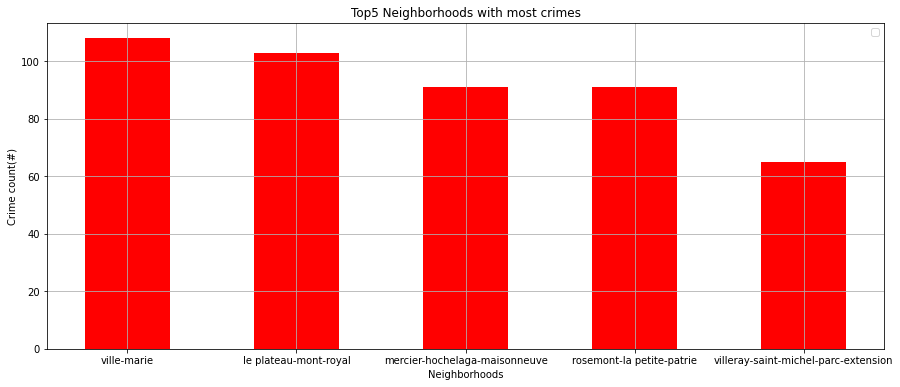

In [21]:
plt.figure(figsize=(15, 6))
X = dfDummyCrime['Neighborhood'].head(5)
X_axis = np.arange(len(X))
plt.title("Top5 Neighborhoods with most crimes")
plt.legend(labels = ['Total'])
plt.bar(dfDummyCrime['Neighborhood'].head(5),dfDummyCrime['Total'].head(5),color="red",align='center',width=0.5)
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

Text(0.5, 0, 'Neighborhoods')

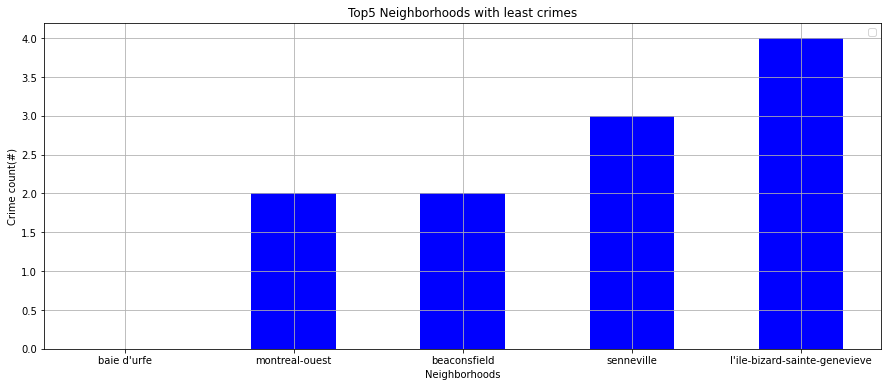

In [22]:
plt.figure(figsize=(15, 6))
X = dfDummyCrime['Neighborhood'].head(5)
X_axis = np.arange(len(X))
plt.title("Top5 Neighborhoods with least crimes")
plt.legend(labels = ['Total'])
plt.bar(dfDummyCrime.sort_values('Total',ascending=True)['Neighborhood'].head(5),dfDummyCrime.sort_values('Total',ascending=True)['Total'].head(5),color="blue",align='center',width=0.5)
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

Text(0.5, 0, 'Neighborhoods')

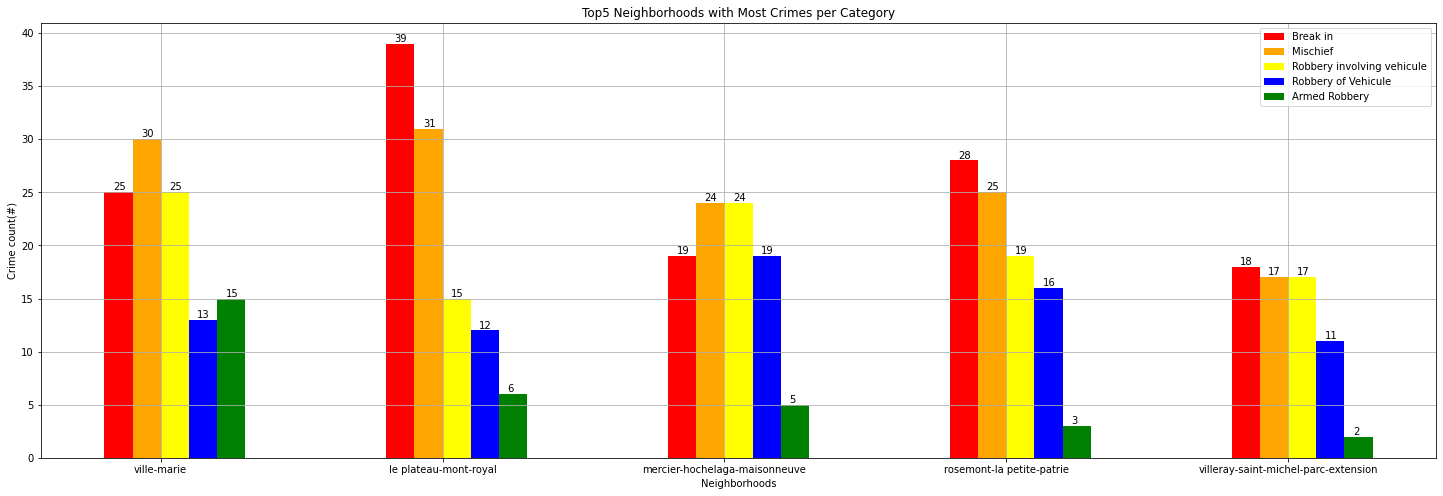

In [23]:
plt.figure(figsize=(25, 8))
plt.title("Top5 Neighborhoods with Most Crimes per Category")
plt.legend(labels = ['Total'])
plt.bar(X_axis - 0.2,dfDummyCrime['Break in'].head(5), color="red",align='edge',width=0.1 , label='Break in')
plt.bar(X_axis - 0.1,dfDummyCrime['Mischief'].head(5),color="orange",align='edge',width=0.1, label='Mischief')
plt.bar(X_axis,dfDummyCrime['Robbery involving vehicule'].head(5),color="Yellow",align='edge',width=0.1, label='Robbery involving vehicule')
plt.bar(X_axis + 0.1,dfDummyCrime['Robbery of Vehicule'].head(5),color="Blue",align='edge',width=0.1, label='Robbery of Vehicule')
plt.bar(X_axis + 0.2,dfDummyCrime['Armed Robbery'].head(5),color="Green",align='edge',width=0.1, label='Armed Robbery')
for index, value in enumerate(dfDummyCrime['Break in'].head(5)):
    plt.text(index-0.17,value+0.2, str(value))
for index, value in enumerate(dfDummyCrime['Mischief'].head(5)):
    plt.text(index-0.07,value+0.2, str(value))
for index, value in enumerate(dfDummyCrime['Robbery involving vehicule'].head(5)):
    plt.text(index+0.03,value+0.2, str(value))
for index, value in enumerate(dfDummyCrime['Robbery of Vehicule'].head(5)):
    plt.text(index+0.13,value+0.2, str(value))
for index, value in enumerate(dfDummyCrime['Armed Robbery'].head(5)):
    plt.text(index+0.23,value+0.2, str(value))
plt.xticks(X_axis,X)
plt.legend()
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

In [24]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfDummyCrime,
                    columns=['Neighborhood', 'Total'],
                    legend_name='Crimes',
                    color='OrRd'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

In [25]:
dfMtlPopulation = pd.read_excel("MontrealStatistique.XLS", sheet_name=2, header=2, usecols=[0,1,5])
dfMtlPopulation.columns = ['Neighborhood','Population','Densite']
dfMtlPopulation = dfMtlPopulation[(dfMtlPopulation["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlPopulation["Neighborhood"] != 'Ville de Montréal') & (dfMtlPopulation["Neighborhood"] != 'Autres villes') & (dfMtlPopulation["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlPopulation = dfMtlPopulation.reset_index(drop=True)
dfMtlPopulation = dfMtlPopulation.iloc[:33]
for x,row in enumerate(dfMtlPopulation.iterrows()):
    dfMtlPopulation.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlPopulation.at[x,"Neighborhood"].lower())
    if dfMtlPopulation.at[x,"Neighborhood"] == 'baie-d\'urfe':
        dfMtlPopulation.at[x,"Neighborhood"] = 'baie d\'urfe'
    if dfMtlPopulation.at[x,"Neighborhood"] == 'dollard-des ormeaux':
        dfMtlPopulation.at[x,"Neighborhood"] = 'dollard-des-ormeaux'


dfMtlRealEstateAVG = pd.read_excel("MontrealStatistique.XLS", sheet_name=22, header=2, usecols=[0,7])
dfMtlRealEstateAVG.columns = ['Neighborhood','Price']
dfMtlRealEstateAVG = dfMtlRealEstateAVG[(dfMtlRealEstateAVG["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlRealEstateAVG["Neighborhood"] != 'Ville de Montréal') & (dfMtlRealEstateAVG["Neighborhood"] != 'Autres villes') & (dfMtlRealEstateAVG["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlRealEstateAVG = dfMtlRealEstateAVG.reset_index(drop=True)
dfMtlRealEstateAVG = dfMtlRealEstateAVG.iloc[:33]
for x,row in enumerate(dfMtlRealEstateAVG.iterrows()):
    dfMtlRealEstateAVG.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlRealEstateAVG.at[x,"Neighborhood"].lower())
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'baie-d\'urfe':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'baie d\'urfe'
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'dollard-des ormeaux':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'dollard-des-ormeaux'
        

dfMTLCensus = pd.merge(dfMtlPopulation,dfMtlRealEstateAVG,how='left',on='Neighborhood')

In [26]:
print('Top5 Montreal Price')
print(dfMTLCensus.sort_values(ignore_index=True,by='Price',ascending=False, axis=0).head(5)[['Neighborhood','Price']])
print('\n')

print('Top5 Montreal Population')
print(dfMTLCensus.sort_values(ignore_index=True,by='Population',ascending=False, axis=0).head(5)[['Neighborhood','Population']])
print('\n')


Top5 Montreal Price
  Neighborhood    Price
0    westmount  1425737
1    hampstead  1147558
2   mont-royal  1017819
3   senneville   982011
4    outremont   896722


Top5 Montreal Population
                           Neighborhood  Population
0   cote-des-neiges-notre-dame-de-grace    166520.0
1  villeray-saint-michel-parc-extension    143853.0
2             rosemont-la petite-patrie    139590.0
3         mercier-hochelaga-maisonneuve    136024.0
4                 ahuntsic-cartierville    134245.0




In [27]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Population'],
                    legend_name='Population',
                    color='BuPu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

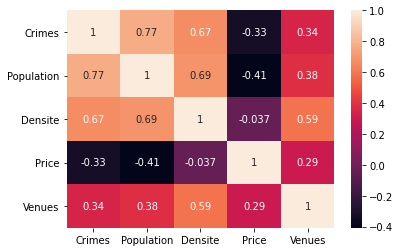

In [28]:
dfTest = pd.merge(left=dfMTLCensus, right=dfMtlVenuesCount,how='left',on='Neighborhood' )
dfTest.rename({"Total":"Venues"},axis='columns',errors="raise",inplace=True)
dfTest = pd.merge(left=dfDummyCrime[['Neighborhood','Total']],right=dfTest,how='left',on='Neighborhood')


dfTest.rename({"Total":"Crimes"},axis='columns',errors="raise",inplace=True)

dfTest = dfTest.sort_values(by='Neighborhood', ascending=True)
dfTest.drop(columns=['Neighborhood'],inplace=True)
dfTest['Crimes'] = dfTest['Crimes'].astype('int64')
dfTest['Price'] = dfTest['Price'].astype('float')
corrMatrix = dfTest.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [29]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Densite'],
                    legend_name='Densite',
                    color='BuPu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

In [30]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Price'],
                    legend_name='Price',
                    color='PuBu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

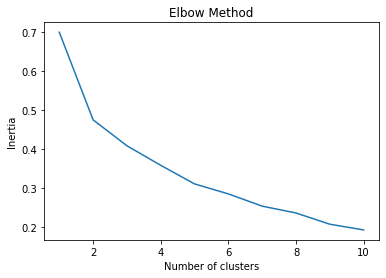

In [31]:
dfMtlGroupedVenues_cluster = dfMtlGroupedVenues.drop(axis=0, columns='Neighborhood')
tabKInert = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(dfMtlGroupedVenues_cluster)
    tabKInert.append(kmeans.inertia_)
plt.plot(range(1,11), tabKInert)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [32]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
kmeans.fit(dfMtlGroupedVenues_cluster)
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenues
dfMtlGroupedVenuesLatLong['Cluster'] = kmeans.labels_[0:33]

In [33]:
#dfCrimeDummyLatLong = dfCrimeDummy.merge(dfMtlPos, left_on='Neighborhood', right_on='Boroughs')
#dfCrimeDummyLatLong = dfCrimeDummyLatLong.drop(axis=0, columns='Boroughs')
#dfCrimeDummyLatLong = dfCrimeDummyLatLong.drop(axis=0, columns='Type')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.merge(dfMtlPos, left_on='Neighborhood', right_on='Boroughs')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.drop(axis=0, columns='Boroughs')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.drop(axis=0, columns='Type')

In [34]:
#dfCrimeDummy.to_excel(r'MontrealCrimeMeanAndCluster.xlsx')
#dfCrimeDummyLatLong
dfMtlGroupedVenuesLatLong.head(5)

Neighborhood  African Restaurant  Airport  \
0                ahuntsic-cartierville                 0.0      0.0   
1                                anjou                 0.0      0.0   
2                          baie d'urfe                 0.0      0.0   
3                         beaconsfield                 0.0      0.0   
4  cote-des-neiges-notre-dame-de-grace                 0.0      0.0   

   Airport Lounge  American Restaurant  Arepa Restaurant  Art Gallery  \
0             0.0             0.000000               0.0         0.00   
1             0.0             0.010000               0.0         0.00   
2             0.0             0.000000               0.0         0.00   
3             0.0             0.011494               0.0         0.00   
4             0.0             0.000000               0.0         0.01   

   Art Museum  Arts & Crafts Store  Asian Restaurant  ...  Warehouse Store  \
0        0.00                 0.00              0.02  ...             0.00   
1        0.00                 0.01              0.00  ...             0.01   
2        0.00                 0.00              0.00  ...             0.00   
3        0.00                 0.00              0.00  ...             0.00   
4        0.01                 0.00              0.00  ...             0.00   

   Wine Bar  Wine Shop  Wings Joint  Yoga Studio       Zoo  Zoo Exhibit  \
0      0.01        0.0          0.0         0.00  0.000000          0.0   
1      0.00        0.0          0.0         0.00  0.000000          0.0   
2      0.00        0.0          0.0         0.00  0.028571          0.0   
3      0.00        0.0          0.0         0.00  0.000000          0.0   
4      0.00        0.0          0.0         0.01  0.000000          0.0   

   Cluster        Lat       Long  
0        3  45.544743 -73.668126  
1        2  45.615958 -73.569351  
2        0  45.416456 -73.916080  
3        2  45.430931 -73.868283  
4        3  45.491151 -73.632653  

[5 rows x 207 columns]

In [35]:
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'grey', 'fillOpacity': 0.2, }

plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add venues to map        
for borough,lat,long,cluster in zip(dfMtlGroupedVenuesLatLong['Neighborhood'],dfMtlGroupedVenuesLatLong['Lat'],dfMtlGroupedVenuesLatLong['Long'],dfMtlGroupedVenuesLatLong['Cluster']):
    label = folium.Popup((borough+' - Cluster'+str(cluster)), parse_html=True)
    if cluster == 0:
        color='red'
    elif cluster == 1:
        color='blue'
    elif cluster == 2:
        color='black'
    elif cluster == 3:
        color='purple'
    elif cluster == 4:
        color='pink'
    elif cluster == 5:
        color='lightblue'
    elif cluster == 6:
        color='white'
    folium.Marker(
        [lat, long],
        popup=label,
        icon=folium.Icon(color=color),
        parse_html=False).add_to(map) 
map

In [36]:
neighborhoods_venues_sorted['Cluster'] = kmeans.labels_[0:33]

In [37]:
neighborhoods_venues_sorted.sort_values('Cluster', ascending=True)

Neighborhood 1st Most Common Venue  \
2                                baie d'urfe           Coffee Shop   
27                   sainte-anne-de-bellevue           Coffee Shop   
23  riviere-des-prairies-pointe-aux-trembles           Coffee Shop   
7                                     dorval           Coffee Shop   
17                              montreal-est              Pharmacy   
16                                mont-royal                  Café   
30                               ville-marie                  Café   
24                 rosemont-la petite-patrie                  Café   
20                                 outremont                  Café   
31      villeray-saint-michel-parc-extension                  Café   
13                     le plateau-mont-royal                  Café   
32                                 westmount                  Café   
12                                   lasalle    Italian Restaurant   
1                                      anjou          Liquor Store   
3                               beaconsfield           Coffee Shop   
25                             saint-laurent        Breakfast Spot   
5                             cote-saint-luc                  Bank   
11                                   lachine                  Café   
21                       pierrefonds-roxboro                  Bank   
6                        dollard-des-ormeaux                  Bank   
22                             pointe-claire                  Bank   
18                             montreal-nord           Supermarket   
9                                   kirkland                  Bank   
15             mercier-hochelaga-maisonneuve          Liquor Store   
10             l'ile-bizard-sainte-genevieve              Pharmacy   
8                                  hampstead                   Pub   
4        cote-des-neiges-notre-dame-de-grace                  Park   
26                             saint-leonard                  Park   
14                              le sud-ouest                  Café   
29                                    verdun                  Café   
19                            montreal-ouest                  Café   
0                      ahuntsic-cartierville                  Café   
28                                senneville    Italian Restaurant   

   2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
2         Sandwich Place    Italian Restaurant   Fast Food Restaurant   
27         Grocery Store        Sandwich Place           Liquor Store   
23           Gas Station          Liquor Store            Supermarket   
7                  Hotel  Fast Food Restaurant         Sandwich Place   
17           Coffee Shop           Supermarket   Fast Food Restaurant   
16                Bakery                  Park      French Restaurant   
30                  Park                Bakery             Restaurant   
24                Bakery                  Park           Liquor Store   
20                Bakery                  Park      French Restaurant   
31                  Park                Bakery            Coffee Shop   
13                Bakery                  Park         Ice Cream Shop   
32                  Park            Restaurant      French Restaurant   
12                  Bank                  Café            Coffee Shop   
1               Pharmacy           Gas Station         Sandwich Place   
3   Fast Food Restaurant          Liquor Store                   Bank   
25                  Bank         Grocery Store            Gas Station   
5                   Café     Indian Restaurant  Vietnamese Restaurant   
11  Fast Food Restaurant                  Bank          Grocery Store   
21           Gas Station  Fast Food Restaurant           Liquor Store   
6     Italian Restaurant        Sandwich Place             Restaurant   
22          Liquor Store      Sushi Restaurant     Italian Restaurant   
18        Sandwich Place                  Par

In [38]:
%%capture
dfMTLCensus['Cluster'] = kmeans.labels_[0:33]
dfDummyCrime['Cluster'] = kmeans.labels_[0:33]

dfCrimeAVG = dfDummyCrime[['Cluster','Total']]
dfCrimeAVG['Total'] = dfCrimeAVG['Total'].astype(int)
dfCrimeAVG = dfCrimeAVG.groupby('Cluster').mean().reset_index()

In [39]:
neighborhoods_venues_sorted[['Neighborhood','Cluster']]

Neighborhood  Cluster
0                      ahuntsic-cartierville        3
1                                      anjou        2
2                                baie d'urfe        0
3                               beaconsfield        2
4        cote-des-neiges-notre-dame-de-grace        3
5                             cote-saint-luc        2
6                        dollard-des-ormeaux        2
7                                     dorval        0
8                                  hampstead        3
9                                   kirkland        2
10             l'ile-bizard-sainte-genevieve        2
11                                   lachine        2
12                                   lasalle        2
13                     le plateau-mont-royal        1
14                              le sud-ouest        3
15             mercier-hochelaga-maisonneuve        2
16                                mont-royal        1
17                              montreal-est        0
18                             montreal-nord        2
19                            montreal-ouest        3
20                                 outremont        1
21                       pierrefonds-roxboro        2
22                             pointe-claire        2
23  riviere-des-prairies-pointe-aux-trembles        0
24                 rosemont-la petite-patrie        1
25                             saint-laurent        2
26                             saint-leonard        3
27                   sainte-anne-de-bellevue        0
28                                senneville        4
29                                    verdun        3
30                               ville-marie        1
31      villeray-saint-michel-parc-extension        1
32                                 westmount        1

In [40]:
%%capture

dfTemp = dfMTLCensus[['Cluster','Price']]
dfTemp['Price'] = dfTemp['Price'].astype(int)
dfTemp = dfTemp.groupby('Cluster').mean()
dfTemp = dfTemp.reset_index()

dfMtlAvgCensus = dfTemp
dfTemp = dfMTLCensus[['Cluster','Population']]
dfTemp['Population'] = dfTemp['Population'].astype(int)
dfTemp = dfTemp.groupby('Cluster').mean()
dfTemp = dfTemp.reset_index()
dfMtlAvgCensus = pd.merge(dfMtlAvgCensus,dfTemp,how='left',on='Cluster')

dfMtlAvgCensus['Price'] = dfMtlAvgCensus['Price'].astype('int64')
dfMtlAvgCensus['Population'] = dfMtlAvgCensus['Population'].astype('int64')

In [41]:
dfMtlAvgCensus

Cluster    Price  Population
0        0   514205       59626
1        1   778824       37329
2        2   455113       67486
3        3   433468       69286
4        4  1017819       20276

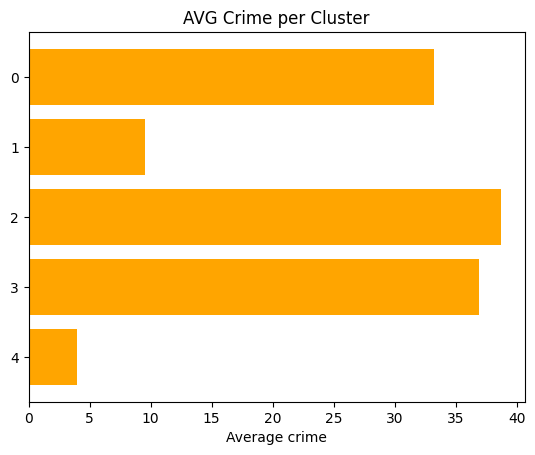

In [42]:
plt.rcdefaults()
fig, ax = plt.subplots()
cluster = dfCrimeAVG['Cluster']
y_pos = np.arange(len(dfCrimeAVG['Cluster']))
avgCrimes = dfCrimeAVG['Total']
#error = np.random.rand(len(dfCrimeAVG['Cluster']))
ax.barh(y_pos, avgCrimes,  align='center',color='orange')
ax.set_yticks(y_pos)
ax.set_yticklabels(cluster)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average crime')
ax.set_title('AVG Crime per Cluster')
plt.show()

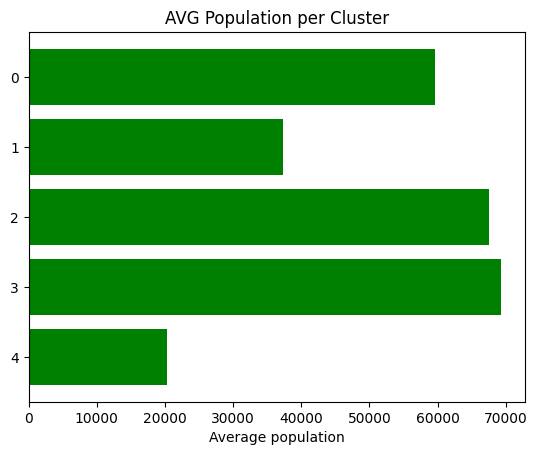

In [43]:
plt.rcdefaults()
fig, ax = plt.subplots()
cluster = dfMtlAvgCensus['Cluster']
y_pos = np.arange(len(dfMtlAvgCensus['Cluster']))
avgCrimes = dfMtlAvgCensus['Population']
#error = np.random.rand(len(dfCrimeAVG['Cluster']))
ax.barh(y_pos, avgCrimes,  align='center',color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(cluster)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average population')
ax.set_title('AVG Population per Cluster')
plt.show()

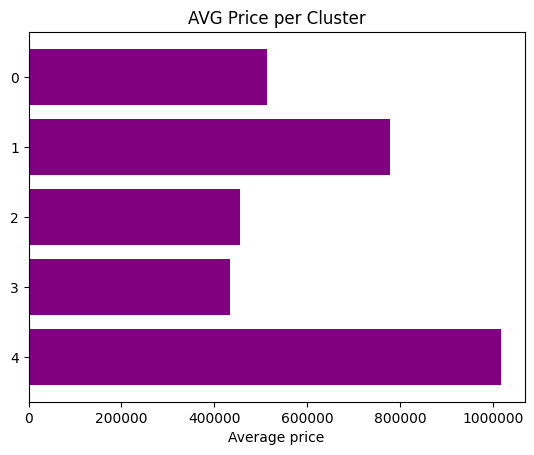

In [44]:
plt.rcdefaults()
fig, ax = plt.subplots()
cluster = dfMtlAvgCensus['Cluster']
y_pos = np.arange(len(dfMtlAvgCensus['Cluster']))
avgCrimes = dfMtlAvgCensus['Price'].astype('int64')
#error = np.random.rand(len(dfCrimeAVG['Cluster']))
ax.barh(y_pos, avgCrimes, align='center',color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(cluster)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average price')
ax.set_title('AVG Price per Cluster')
ax.ticklabel_format(style='plain', axis='x')
plt.show()